In [46]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp 
from gurobipy import GRB, quicksum
import torch
"""
The user MUST install Gurobi to use this program.
Check https://www.gurobi.com/ for installation details.
"""

def Solve1BitCS(y,Z,m,d,s):
    '''
    This function creates a quadratic programming model, calls Gurobi
    and solves the 1 bit CS subproblem. This function can be replaced with
    any suitable function that calls a convex optimization package.
    =========== INPUTS ==============
    y ........... length m vector of one-bit measurements
    Z ........... m-by-d sensing matrix
    m ........... number of measurements
    d ........... dimension of problem
    s ........... sparsity level
    
    =========== OUTPUTS =============
    x_hat ....... Solution. Note that ||x_hat||_2 = 1
    '''   
    model = gp.Model("1BitRecovery")
    x = model.addVars(2*d, vtype = GRB.CONTINUOUS)
    c1 = np.dot(y.T,Z)
    c = list(np.concatenate((c1,-c1)))

    model.setObjective(quicksum(c[i]*x[i] for i in range(0,2*d)), GRB.MAXIMIZE)
    model.addConstr(quicksum(x) <= np.sqrt(s),"ell_1")  # sum_i x_i <=1
    model.addConstr(quicksum(x[i]*x[i] for i in range(0,2*d)) - 2*quicksum(x[i]*x[d+i] for i in range(0,d))<= 1, "ell_2") # sum_i x_i^2 <= 1
    model.addConstrs(x[i] >= 0 for i in range(0,2*d))
    model.Params.OUTPUTFLAG = 0

    model.optimize()
    TempSol = model.getAttr('x')
    x_hat = np.array(TempSol[0:d] - np.array(TempSol[d:2*d]))
    return x_hat

class QuadraticObj:
    
    def __init__(self, d=20, hidden_d=10):
        self.dim = d
        self.quadratic = np.random.randn(d,hidden_d)
        self.quadratic = np.matmul(self.quadratic, self.quadratic.T)
        self.linear = np.random.randn(d,1)
    
    def value_oracle(self, x):
        x_re = x.reshape(1,self.dim)
        obj = np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear)
        return obj[0][0]
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.reshape(1,self.dim) for x in x_list]
        value_list = [(np.matmul(np.matmul(x_re,self.quadratic), x_re.T) + np.matmul(x_re, self.linear))[0][0] for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):   
        tensor_x = torch.tensor(x, requires_grad = True)
        x_re = tensor_x.reshape(1,self.dim)
        obj = torch.matmul(torch.matmul(x_re,torch.tensor(self.quadratic)), x_re.T) + torch.matmul(x_re, torch.tensor(self.linear))
        obj.backward()
        return tensor_x.grad.numpy()

    
    
class NonConvexObj:
    
    def __init__(self, d=20):
        self.dim = d
    
    def value_oracle(self, x):
        x_re = x.copy()
        obj = np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2)
        return obj
    
    def rank_oracle(self, x_list, top = -1):
        x_re_list = [x.copy() for x in x_list]
        value_list = [np.sum(100 * ((x_re[1:] - (x_re[:-1] ** 2))**2) + (1-x_re[:-1]) ** 2) for x_re in x_re_list]
        if top == -1:
            return np.argsort(value_list)
        else:
            return np.argsort(value_list)[:top]
        
    def gradient_oracle(self, x):
        tensor_x = torch.tensor(x, requires_grad = True)
        obj = torch.sum(100 * ((tensor_x[1:] - (tensor_x[:-1] ** 2))**2) + (1-tensor_x[:-1]) ** 2)
        obj.backward()
        return tensor_x.grad.numpy()

In [99]:
dim  = 20

In [106]:
objective = QuadraticObj(d=dim,hidden_d=dim//2)

In [100]:
objective = NonConvexObj(d=dim)

In [107]:
initial = np.random.randn(objective.dim)
total_steps = 200
reps = 10

In [108]:
# simple zo algorithm
total_zo_hist = []
for _ in range(reps):
    zo_hist = []
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 5
    mu = 0.1
    lr = 1
    line_search = 4
    for _ in range(total_steps):
        grad_est = np.zeros_like(x)
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            grad_est += (objective.value_oracle(x + mu * random_d) - cur_obj) * random_d / mu
        grad_est /= np.linalg.norm(grad_est)
        if line_search > 0:
            line_search_candidates = [x - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            line_search_values = [objective.value_oracle(xc) for xc in line_search_candidates]
            x = line_search_candidates[np.argmin(line_search_values)]
        else:
            x = x - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_hist.append(cur_obj)
    total_zo_hist.append(zo_hist)



In [109]:
# simple fo algorithm
total_fo_hist = []
for _ in range(reps):
    fo_hist = []
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    lr = 1
    line_search = 4
    for _ in range(total_steps):
        grad_est = objective.gradient_oracle(x)
        grad_est /= np.linalg.norm(grad_est)
        if line_search > 0:
            line_search_candidates = [x - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            line_search_values = [objective.value_oracle(xc) for xc in line_search_candidates]
            x = line_search_candidates[np.argmin(line_search_values)]
        else:
            x = x - lr * grad_est
        cur_obj = objective.value_oracle(x)
        fo_hist.append(cur_obj)
    total_fo_hist.append(fo_hist)

In [110]:
# rank-based optimization
def grad_est_from_rank(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
    Z = []
    y = []
    if with_order:
        for ii, x0 in enumerate(query_rank[:-1]):
            for jj, x1 in enumerate(query_rank[(ii+1):]):
                now_z = query_list[x1]-query_list[x0]
                Z.append(now_z / np.linalg.norm(now_z))
                y.append(1)
    if len(query_list) > len(query_rank):
        for x0, qx0 in enumerate(query_list):
            if x0 not in query_rank:
                for top_x0 in query_rank:
                    now_z = qx0 - query_list[top_x0]
                    Z.append(now_z / np.linalg.norm(now_z))
                    y.append(1)
    
    y=np.array(y)
    Z=np.array(Z)
    #print(Z.shape)
    #grad_est = Solve1BitCS(y,Z,Z.shape[0],Z.shape[1],sparsity)
    grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    return grad_est/np.linalg.norm(grad_est)

total_zo_rank_hist = []

zo_rank_grad_hist = []

for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 5
    top = 6
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_rank_hist= []

    with_order = True

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, top)
        grad_est = grad_est_from_rank(query_list,query_rank,sparsity,mu,with_order)
        
        true_grad = objective.gradient_oracle(query_list[query_rank[0]])
        true_grad /= np.linalg.norm(true_grad)
        zo_rank_grad_hist.append(np.dot(grad_est,true_grad))
        
        
        if line_search > 0:
            line_search_candidates = [query_list[query_rank[0]] - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            x = line_search_candidates[objective.rank_oracle(line_search_candidates)[0]]
        else:
            x = query_list[query_rank[0]] - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_rank_hist.append(cur_obj)
    total_zo_rank_hist.append(zo_rank_hist)

In [64]:
# rank-based optimization - direct search
total_ds_rank_hist = []
for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 10
    mu = 0.1
    ds_rank_hist= []

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, 1)
        x = query_list[query_rank[0]]
        cur_obj = objective.value_oracle(x)
        ds_rank_hist.append(cur_obj)
    total_ds_rank_hist.append(ds_rank_hist)

In [74]:
# cma
from cma import CMAEvolutionStrategy
variance = 0.01
query_num = 14

total_es_hist = []
for _ in range(reps):
    es = CMAEvolutionStrategy(list(initial), variance, {'popsize':query_num})
    es_hist= []
    for _ in range(total_steps):
        solutions = es.ask()
        values = [objective.value_oracle(np.array(x)) for x in solutions]
        es_hist.append(np.min(values))
        es.tell(solutions, values)
    total_es_hist.append(es_hist)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=438058, Tue Dec  6 19:02:50 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=336854, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=359567, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=420470, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=473272, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=483687, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=457726, Tue Dec  6 19:02:51 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=333689, Tue Dec  6 19:02:52 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=355020, Tue Dec  6 19:02:52 2022)
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 10 (seed=392115, Tue Dec  6 19:02:52 2022)


In [8]:
# pure comparison-based opt

def grad_est_from_compare(query_list,query_values,sparsity = 10,mu = 0.1):
    Z = [qx-query_list[0] for qx in query_list[1:]]
    y = [np.sign(qv - query_values[0]) for qv in query_values[1:]]
#     zero_index = list(query_rank).index(0)
#     for ii, x0 in enumerate(query_rank):
#         if ii < zero_index:
#             Z.append(query_list[0]-query_list[x0])
#             y.append(1)
#         elif ii > zero_index:
#             Z.append(query_list[x0]-query_list[0])
#             y.append(1)
#         else:
#             continue
    

    y=np.array(y)
    Z=np.array(Z)
    #print(Z.shape)
#     grad_est = Solve1BitCS(y,Z,Z.shape[0],Z.shape[1],sparsity)
    grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    return grad_est

total_zo_comp_hist = []
zo_comp_grad_hist = []
line_search = 4
for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 10
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_comp_hist= []

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_values= [objective.value_oracle(qx) for qx in  query_list]
        grad_est = grad_est_from_compare(query_list,query_values,sparsity,mu)
        
        true_grad = objective.gradient_oracle(x)
        true_grad /= np.linalg.norm(true_grad)
        zo_comp_grad_hist.append(np.dot(grad_est,true_grad))
        
        if line_search > 0:
            line_search_candidates = [x - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            line_search_values = [objective.value_oracle(xc) for xc in line_search_candidates]
            x = line_search_candidates[np.argmin(line_search_values)]
        else:
            x = x - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_comp_hist.append(cur_obj)
    total_zo_comp_hist.append(zo_comp_hist)

In [9]:
# pure comparison-based opt - noise

def grad_est_from_compare(query_list,query_values,sparsity = 10,mu = 0.1):
    ns = 0
    Z = [qx-query_list[0] for qx in query_list[1:]]
    y = [np.sign(qv - query_values[0] + ns * np.random.rand()) for qv in query_values[1:]]
#     zero_index = list(query_rank).index(0)
#     for ii, x0 in enumerate(query_rank):
#         if ii < zero_index:
#             Z.append(query_list[0]-query_list[x0])
#             y.append(1)
#         elif ii > zero_index:
#             Z.append(query_list[x0]-query_list[0])
#             y.append(1)
#         else:
#             continue
    

    y=np.array(y)
    Z=np.array(Z)
    #print(Z.shape)
#     grad_est = Solve1BitCS(y,Z,Z.shape[0],Z.shape[1],sparsity)
    grad_est = np.matmul(y.reshape(1,-1),Z).flatten()
    return grad_est/np.linalg.norm(grad_est)

total_zo_comp_ns_hist = []
zo_comp_ns_grad_hist = []
line_search = 4
for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 10
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_comp_ns_hist= []

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_values= [objective.value_oracle(qx) + np.random.randn()*1 for qx in  query_list]
        grad_est = grad_est_from_compare(query_list,query_values,sparsity,mu)
        
        true_grad = objective.gradient_oracle(x)
        true_grad /= np.linalg.norm(true_grad)
        zo_comp_ns_grad_hist.append(np.dot(grad_est,true_grad))
        
        if line_search > 0:
            line_search_candidates = [x - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            line_search_values = [objective.value_oracle(xc) for xc in line_search_candidates]
            x = line_search_candidates[np.argmin(line_search_values)]
        else:
            x = x - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_comp_ns_hist.append(cur_obj)
    total_zo_comp_ns_hist.append(zo_comp_ns_hist)

In [126]:
# es-like direction
def grad_est_from_rank_es_like(query_list,query_rank,sparsity = 10,mu = 0.1,with_order = True):
    relative_rank = np.array([np.where(query_rank==ii)[0][0]+1 for ii in range(len(query_rank))])
    weight = relative_rank - relative_rank[0]
    
    grad_est = np.sum([(query_list[ii]-query_list[0])*weight[ii] for ii in range(1,len(query_rank))])
    
    return grad_est/np.linalg.norm(grad_est)

total_zo_rank_es_like_hist = []

zo_rank_grad_es_like_hist = []

for _ in range(reps):
    x = initial.copy()
    cur_obj = objective.value_oracle(x)
    query_num = 10
    top = query_num+1
    mu = 0.1
    sparsity =10000
    lr = 1
    zo_rank_es_like_hist= []

    with_order = True

    for _ in range(total_steps):
        query_list = [x]
        for _ in range(query_num):
            random_d = np.random.randn(objective.dim)
            random_d /= np.linalg.norm(random_d)
            query_list.append(x+mu * random_d)
        query_rank = objective.rank_oracle(query_list, top)
        grad_est = grad_est_from_rank_es_like(query_list,query_rank,sparsity,mu,with_order)
        
        true_grad = objective.gradient_oracle(query_list[query_rank[0]])
        true_grad /= np.linalg.norm(true_grad)
        zo_rank_grad_es_like_hist.append(np.dot(grad_est,true_grad))
        
        
        if line_search > 0:
            line_search_candidates = [query_list[query_rank[0]] - lr * scale * grad_est for scale in lr / np.power(2, np.arange(line_search))]
            x = line_search_candidates[objective.rank_oracle(line_search_candidates)[0]]
        else:
            x = query_list[query_rank[0]] - lr * grad_est
        cur_obj = objective.value_oracle(x)
        zo_rank_es_like_hist.append(cur_obj)
    total_zo_rank_es_like_hist.append(zo_rank_es_like_hist)

In [114]:
query_rank

array([1, 0, 4, 2, 5, 3])

array([2, 1, 4, 6, 3, 5])

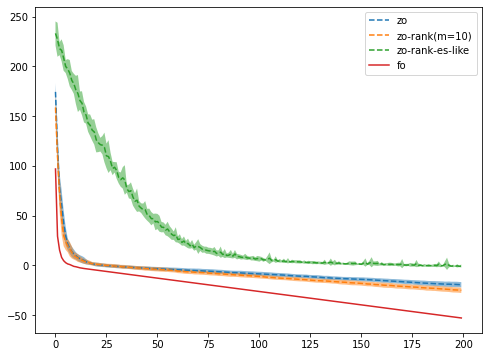

In [128]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

total_zo_hist = np.array(total_zo_hist)
total_zo_mean = total_zo_hist.mean(0)
total_zo_std = total_zo_hist.std(0)
plt.plot(total_zo_mean,"--",label = "zo")
plt.fill_between(np.arange(total_steps),total_zo_mean - total_zo_std,total_zo_mean + total_zo_std, alpha=0.5)

total_zo_rank_hist = np.array(total_zo_rank_hist)
total_zo_rank_mean = total_zo_rank_hist.mean(0)
total_zo_rank_std = total_zo_rank_hist.std(0)
plt.plot(total_zo_rank_mean,"--", label = "zo-rank(m=10)")
plt.fill_between(np.arange(total_steps),total_zo_rank_mean - total_zo_rank_std,total_zo_rank_mean + total_zo_rank_std, alpha=0.5)

total_zo_rank_es_like_hist = np.array(total_zo_rank_es_like_hist)
total_zo_rank_es_like_mean = total_zo_rank_es_like_hist.mean(0)
total_zo_rank_es_like_std = total_zo_rank_es_like_hist.std(0)
plt.plot(total_zo_rank_es_like_mean,"--", label = "zo-rank-es-like")
plt.fill_between(np.arange(total_steps),total_zo_rank_es_like_mean - total_zo_rank_es_like_std,total_zo_rank_es_like_mean + total_zo_rank_es_like_std, alpha=0.5)

# total_zo_comp_hist = np.array(total_zo_comp_hist)
# total_zo_comp_mean = total_zo_comp_hist.mean(0)
# total_zo_comp_std = total_zo_comp_hist.std(0)
# plt.plot(total_zo_comp_mean, label = "zo-comp(m=10)")
# plt.fill_between(np.arange(total_steps),total_zo_comp_mean - total_zo_comp_std,total_zo_comp_mean + total_zo_comp_std, alpha=0.5)

# total_zo_comp_ns_hist = np.array(total_zo_comp_ns_hist)
# total_zo_comp_ns_mean = total_zo_comp_ns_hist.mean(0)
# total_zo_comp_ns_std = total_zo_comp_ns_hist.std(0)
# plt.plot(total_zo_comp_ns_mean, label = "zo-comp(ns)")
# plt.fill_between(np.arange(total_steps),total_zo_comp_ns_mean - total_zo_comp_ns_std,total_zo_comp_ns_mean + total_zo_comp_ns_std, alpha=0.5)

# total_es_hist = np.array(total_es_hist)
# total_es_mean = total_es_hist.mean(0)
# total_es_std = total_es_hist.std(0)
# plt.plot(total_es_mean, label = "es")
# plt.fill_between(np.arange(total_steps),total_es_mean - total_es_std,total_es_mean + total_es_std, alpha=0.5)

# total_ds_rank_hist = np.array(total_ds_rank_hist)
# total_ds_rank_mean = total_ds_rank_hist.mean(0)
# total_ds_rank_std = total_ds_rank_hist.std(0)
# plt.plot(total_ds_rank_mean, label = "direct search")
# plt.fill_between(np.arange(total_steps),total_ds_rank_mean - total_ds_rank_std,total_ds_rank_mean + total_ds_rank_std, alpha=0.5)

total_fo_hist = np.array(total_fo_hist)
total_fo_mean = total_fo_hist.mean(0)
total_fo_std = total_fo_hist.std(0)
plt.plot(fo_hist, label = "fo")
plt.fill_between(np.arange(total_steps),total_fo_mean - total_fo_std,total_fo_mean + total_fo_std, alpha=0.5)

plt.legend()
#plt.title("m=30")

NameError: name 'zob_comp_grad_hist' is not defined

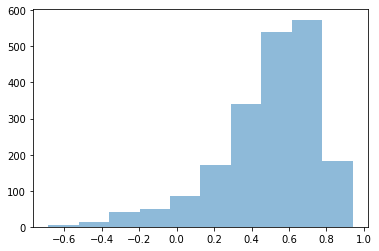

In [75]:
plt.hist(zo_rank_grad_hist,label="rank",alpha=0.5)
plt.hist(zob_comp_grad_hist,label="comp",alpha=0.5)
plt.legend()

# unbiased?

In [322]:
dim=10
m=10
x = np.random.rand(dim,1) + 2
x = x/np.linalg.norm(x)

In [53]:

reps = 10000
re_x = []
for _ in range(reps):
    Z = np.random.randn(m,dim)
    Z /= np.linalg.norm(Z,axis=1).reshape(m,-1)
    y = np.sign(np.matmul(Z,x).flatten())

    
    now_rex = np.matmul(y.reshape(1,-1),Z).flatten()
    re_x.append(now_rex/np.linalg.norm(now_rex))
    #re_x.append(Solve1BitCS(y,Z,m,dim,10000))
#print(np.linalg.norm(x.flatten()-re_x/reps))

mean_re_x = np.zeros(dim)
results = []
for n in range(1,reps+1):
    mean_re_x += re_x[n-1] 
    if n in [1,10,100,1000,10000]:
        test_x = mean_re_x/n
        test_x /= np.linalg.norm(test_x)
        results.append(np.linalg.norm(x.flatten()-test_x))
        
plt.plot(results)
plt.plot(np.zeros_like(results))
plt.title("m=1000")
plt.xlabel("n")
plt.ylabel(r"$||x-\sum_{i=1}^n \frac{\hat x_i}{n}||$")
plt.xticks([0,1,2,3,4],[1,10,100,1000,10000])

NameError: name 'm' is not defined

([<matplotlib.axis.XTick at 0x7fb9c3e86070>,
 [Text(0, 0, '1'),
  Text(1, 0, '10'),
  Text(2, 0, '100'),
  Text(3, 0, '1000'),
  Text(4, 0, '10000'),
  Text(5, 0, '100000')])

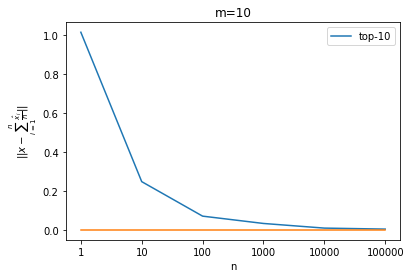

In [320]:
dim=10
m=10
x = np.random.rand(dim,1) + 2
x = x/np.linalg.norm(x)
reps = 100000
re_x = []
topk=10
for _ in range(reps):
    Z = np.random.randn(m,dim)
    Z /= np.linalg.norm(Z,axis=1).reshape(m,-1)
    Z = np.concatenate([Z,np.zeros((1,dim))],0)
    ry = np.matmul(Z,x).flatten()
    y_rank = np.argsort(ry)[:topk]
    
    
    Zy = []
    y = []
    for ii, x0 in enumerate(y_rank[:-1]):
            for jj, x1 in enumerate(y_rank[(ii+1):]):
                now_z = Z[x1]-Z[x0]
                Zy.append(now_z)
                y.append(1)
                
    if len(Z) > len(y_rank):
        for x0, qx0 in enumerate(Z):
            if x0 not in y_rank:
                for top_x0 in y_rank:
                    now_z = qx0 - Z[top_x0]
                    Zy.append(now_z)
                    y.append(1)
    
    y=np.array(y)
    Zy=np.array(Zy)
    
    now_rex = np.matmul(y.reshape(1,-1),Zy).flatten()
    re_x.append(now_rex/np.linalg.norm(now_rex))
    #re_x.append(Solve1BitCS(y,Z,m,dim,10000))
#print(np.linalg.norm(x.flatten()-re_x/reps))

mean_re_x = np.zeros(dim)
results_rank = []
for n in range(1,reps+1):
    mean_re_x += re_x[n-1] 
    if n in [1,10,100,1000,10000,100000]:
        test_x = mean_re_x/n
        test_x /= np.linalg.norm(test_x)
        results_rank.append(np.linalg.norm(x.flatten()-test_x))
        
#plt.plot(results,label="w/o rank")
plt.plot(results_rank,label="top-{}".format(topk))
plt.plot(np.zeros_like(results_rank))
plt.title("m=10")
plt.xlabel("n")
plt.legend()
plt.ylabel(r"$||x-\sum_{i=1}^n \frac{\hat x_i}{n}||$")
plt.xticks([0,1,2,3,4,5],[1,10,100,1000,10000,100000])

In [245]:
x=initial

In [287]:
x

array([47.47303132, 83.7356713 ])

In [41]:
grad_est = np.zeros_like(x)
grad_est_rank  = np.zeros_like(x)
grad_est_comp = np.zeros_like(x)
mu = 0.01
for _ in range(10000):
    query_list = [x]
    query_num = 10
    temp_grad = np.zeros_like(x)
    for _ in range(query_num):
        random_d = np.random.randn(objective.dim)
        random_d /= np.linalg.norm(random_d)
        query_list.append(x+mu * random_d)
        temp_grad += (objective.value_oracle(x + mu * random_d) - objective.value_oracle(x)) * random_d 
    grad_est += temp_grad / np.linalg.norm(temp_grad)
    query_values= [objective.value_oracle(qx) for qx in  query_list]
    query_rank = objective.rank_oracle(query_list[1:], len(query_list)+1)
    grad_est_rank += grad_est_from_rank(query_list[1:],query_rank,sparsity,mu,with_order) 
    grad_est_comp += grad_est_from_compare(query_list,query_values,sparsity,mu) 



In [42]:
grad_est/np.linalg.norm(grad_est)

array([-0.8508038 ,  0.52548348])

In [43]:
grad_est_comp /np.linalg.norm(grad_est_comp)

array([-0.85017721,  0.52649664])

In [44]:
grad_est_rank /np.linalg.norm(grad_est_rank)

array([-0.8519216 ,  0.52366935])

In [45]:
objective.gradient_oracle(x)/np.linalg.norm(objective.gradient_oracle(x))

array([-0.85029316,  0.52630936])